In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

sns.set(rc={"figure.figsize": (13, 10)})

In [2]:
train_data = pd.read_csv("./data/train.csv", index_col='id')
valid_data = pd.read_csv("./data/test.csv", index_col='id')
datasets = [train_data, valid_data]
train_data.shape, valid_data.shape


((26570, 25), (20775, 24))

## Define constants

In [3]:
TARGET = "failure"
SEED = 0

## Encode categorical data

In [4]:
# load csv and set id column as index

# lable encode categorical columns
cat_cols = ['product_code', 'attribute_0', 'attribute_1']

for data in datasets:
    for col in cat_cols:
        data[col] = data[col].astype('category').cat.codes

train_data.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,0,80.10,1,2,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,0,84.89,1,2,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,0,82.43,1,2,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,0,101.07,1,2,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,0,188.06,1,2,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


## Fill None values by median

In [5]:
for data in datasets:
    for col in data.filter(regex='measurement_').columns.tolist():
        data[col] = data.groupby('product_code')[col].transform(lambda x: x.fillna(x.median()))
        
    data['loading'] = data.groupby('product_code')['loading'].transform(lambda x: x.fillna(x.median()))

In [6]:
data.isna().sum().sum()

0

In [7]:
# apply StandardScaler to continuous columns
# scaler = StandardScaler()
# cols = train_data.columns.drop(cat_cols + ['product_code', 'attribute_2', 'attribute_3', TARGET]).tolist()
# train_data[cols] = scaler.fit_transform(train_data[cols])


# scaler = StandardScaler()
# cols = valid_data.columns.drop(cat_cols + ['product_code', 'attribute_2', 'attribute_3']).tolist()
# valid_data[cols] = scaler.fit_transform(valid_data[cols])


In [8]:
train_data.head(3)

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,0,80.10,1,2,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,16.0265,13.034,14.684,764.100,0
1,0,84.89,1,2,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.4250,14.395,15.631,682.057,0
2,0,82.43,1,2,9,5,12,1,5,18.057,...,12.715,15.607,19.460,13.798,16.711,18.6310,14.094,17.946,663.376,0


In [9]:
valid_data.head(3)

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
id,,,,,,,,,,,,,,,,,,,,,
26570,0,119.57,0,1,6,4,6,9,6,19.305,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
26571,0,113.51,0,1,6,4,11,8,0,17.883,...,19.368,12.032,13.998,18.104,12.473,17.468,16.708,14.776,14.102,537.037
26572,0,112.16,0,1,6,4,8,12,4,18.475,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995


## Analys unnessesary columns

In [10]:
unnesessary_columns = [f'measurement_{i}' for i in range(0, 3)] + \
    [f'measurement_{i}' for i in range(10, 18)]
unnesessary_columns

['measurement_0',
 'measurement_1',
 'measurement_2',
 'measurement_10',
 'measurement_11',
 'measurement_12',
 'measurement_13',
 'measurement_14',
 'measurement_15',
 'measurement_16',
 'measurement_17']

In [11]:
train_data = train_data.drop(unnesessary_columns, axis=1)
valid_data = valid_data.drop(unnesessary_columns, axis=1)

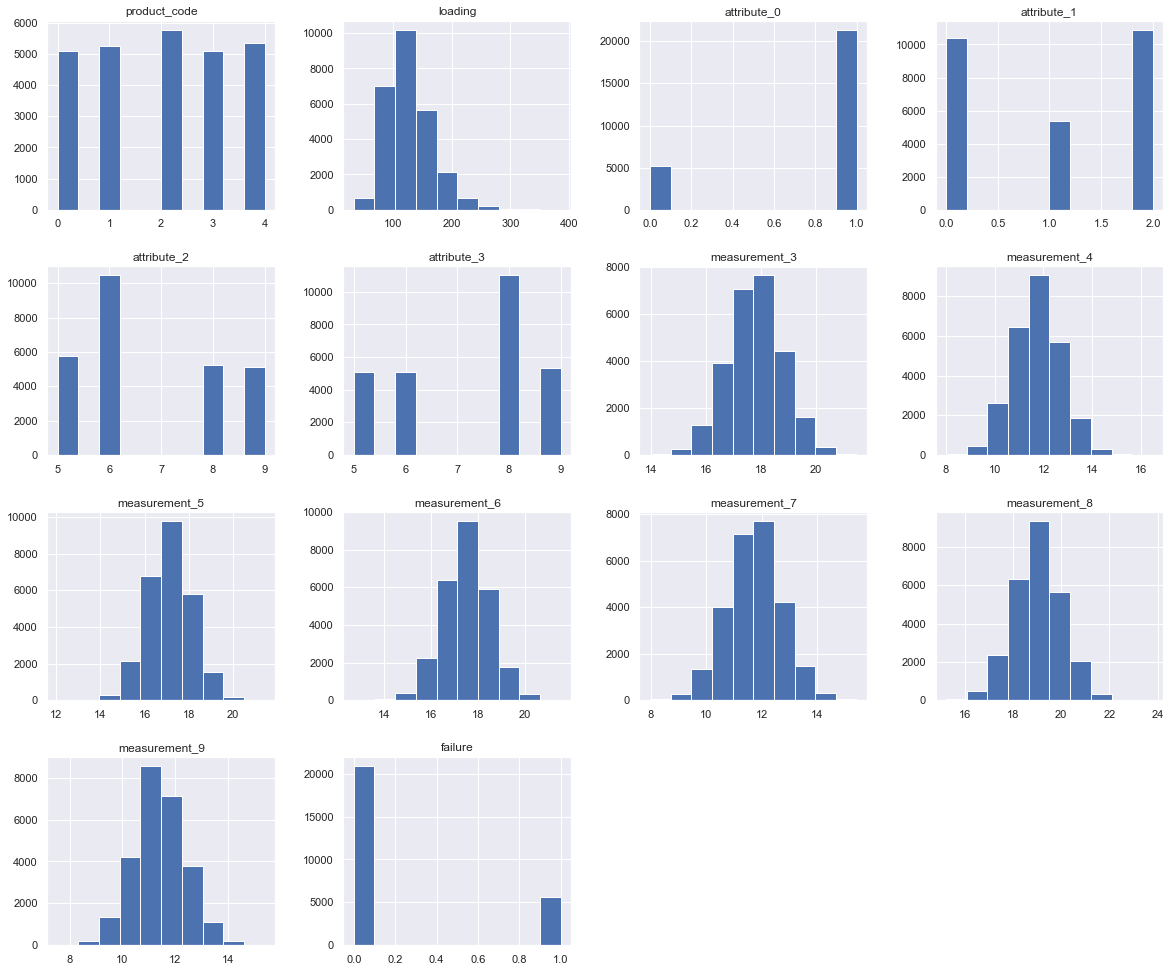

In [12]:
train_data[:].hist(figsize=(20, 17))
None

# Train Model

In [13]:
X = train_data.drop(columns=TARGET)
y = train_data[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED)

In [14]:
params = {
    "n_estimators": range(10, 50, 10),
    "max_depth": range(1, 12, 2),
    # "min_samples_leaf": range(1, 8),
    # "min_samples_split": range(2, 10, 2)
}

In [15]:
clf = RandomForestClassifier()
grid_search_cv = GridSearchCV(clf, params, cv=3, n_jobs=-1)
grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 12, 2),
                         'n_estimators': range(10, 50, 10)})

In [16]:
best_solution = grid_search_cv.best_estimator_
best_solution

RandomForestClassifier(max_depth=3, n_estimators=10)

In [17]:
best_solution.score(X_test, y_test)

0.7914243357281332

## Create submission

In [18]:
solution = best_solution.predict(valid_data)
submission = pd.read_csv("./data/sample_submission.csv")
submission[TARGET] = solution
submission.head()

,id,failure
0,26570,0
1,26571,0
2,26572,0
3,26573,0
4,26574,0


In [19]:
submission[["id", TARGET]].to_csv("./data/solution.csv", index=False)